<a href="https://colab.research.google.com/github/arnavprasad/soccer-knowledge-graph/blob/master/knowledge_soccer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install wikipedia-api -q

In [2]:
pip install plotly==4.7.0 -q

     |████████████████████████████████| 11.5MB 361kB/s 


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go

In [4]:
import pandas as pd
import concurrent.futures
from tqdm import tqdm
import wikipediaapi 

In [5]:
pip install neuralcoref -q

     |████████████████████████████████| 296kB 2.8MB/s 


In [6]:
pip install spacy -q

In [7]:

import pandas as pd
import re
import spacy

nlp = spacy.load('en')

import wikipediaapi
import pandas as pd

def wiki_page(page_name):
    wiki_api = wikipediaapi.Wikipedia(language='en',
                                      extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(page_name)
    if not page_name.exists():
        print('page does not exist')
        return
    page_data = {'page': page_name, 'text': page_name.text, 'link': page_name.fullurl,
                 'categories': [[y[9:] for y in list(page_name.categories.keys())]]}
    page_data_df = pd.DataFrame(page_data)
    return page_data_df
    
import wikipediaapi  # pip install wikipedia-api
import pandas as pd
import concurrent.futures
from tqdm import tqdm

def wiki_scrape(topic_name, verbose=True):
    def wiki_link(link):
        try:
            page = wiki_api.page(link)
            if page.exists():
                d = {'page': link, 'text': page.text, 'link': page.fullurl,
                     'categories': list(page.categories.keys())}
                return d
            else:
                return None
        except:
            return None

    wiki_api = wikipediaapi.Wikipedia(language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(topic_name)
    if not page_name.exists():
        print('page does not exist')
        return
    page_links = list(page_name.links.keys())
    progress = tqdm(desc='Links Scraped', unit='', total=len(page_links)) if verbose else None
    sources = [{'page': topic_name, 'text': page_name.text, 'link': page_name.fullurl,
                'categories': list(page_name.categories.keys())}]
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        future_link = {executor.submit(wiki_link, link): link for link in page_links}
        for future in concurrent.futures.as_completed(future_link):
            data = future.result()
            progress.update(1) if verbose else None
            if data:
                sources.append(data)
    progress.close() if verbose else None
    blacklist = ('Template', 'Help:', 'Category:', 'Portal:', 'Wikipedia:', 'Talk:')
    sources = pd.DataFrame(sources)
    sources = sources[(len(sources['text']) > 20)
                      & ~(sources['page'].str.startswith(blacklist))]
    sources['categories'] = sources.categories.apply(lambda x: [y[9:] for y in x])
    return sources

def entity_pairs(text):
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    
    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = list()
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = spacy.util.filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span) for span in spans]
        dep = [token.dep_ for token in sent]
        if (dep.count('obj')+dep.count('dobj'))==1 \
                and (dep.count('subj')+dep.count('nsubj'))==1:
            for token in sent:
                if token.dep_ in ('obj', 'dobj'):  # identify object nodes
                    subject = [w for w in token.head.lefts if w.dep_
                               in ('subj', 'nsubj')]  # identify subject nodes
                    if subject:
                        subject = subject[0]
                        # identify relationship by root dependency
                        relation = [w for w in token.ancestors if w.dep_ == 'ROOT']  
                        if relation:
                            relation = relation[0]
                            # add adposition or particle to relationship
                            if relation.nbor(1).pos_ in ('ADP', 'PART'):  
                                relation = ' '.join((str(relation),
                                        str(relation.nbor(1))))
                        else:
                            relation = 'unknown'
                        subject, subject_type = refine_ent(subject, sent)
                        token, object_type = refine_ent(token, sent)
                        ent_pairs.append([str(subject), str(relation), str(token),
                                str(subject_type), str(object_type)])
    filtered_ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(x) == '' for x in sublist)]
    pairs = pd.DataFrame(filtered_ent_pairs, columns=['subject',
                         'relation', 'object', 'subject_type',
                         'object_type'])
    print('Entity pairs extracted:', str(len(filtered_ent_pairs)))
    return pairs


def refine_ent(ent, sent):
    unwanted_tokens = (
        'PRON',  # pronouns
        'PART',  # particle
        'DET',  # determiner
        'SCONJ',  # subordinating conjunction
        'PUNCT',  # punctuation
        'SYM',  # symbol
        'X',  # other
        )
    ent_type = ent.ent_type_  # get entity type
    if ent_type == '':
        ent_type = 'NOUN_CHUNK'
        ent = ' '.join(str(t.text) for t in
                nlp(str(ent)) if t.pos_
                not in unwanted_tokens and t.is_stop == False)
    elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
        t = ''
        for i in range(len(sent) - ent.i):
            if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                t += ' ' + str(ent.nbor(i))
            else:
                ent = t.strip()
                break
    return ent, ent_type

In [8]:
wiki_data = wiki_scrape('Wayne Rooney')
#wiki_data['text'] = wiki_data['text'].str[0]

Links Scraped: 100%|██████████| 905/905 [00:53<00:00, 16.90/s]


In [9]:
string = wiki_data.loc[0, "text"]
for i in range(5):

   string += wiki_data.loc[i, "text"]


In [10]:
pairs = entity_pairs(string)

Entity pairs extracted: 145


In [11]:
pairs['subject'].unique()

array(['Rooney', 'Everton', 'United', 'Bayern', 'following game', 'goals',
       'rivals', 'team', 'Cristiano Ronaldo', 'Elizondo',
       'The Daily Telegraph', 'couple', 'bishop office', 'Rooney wife',
       'the WIPO', 'club', 'Flags', 'Players', 'Denmark', 'Sir Alex',
       'match', 'ITV Digital crisis', 'collapse', 'Dario', 'Dario Gradi',
       'newly promoted division sides', 'Stockport County', 'Liverpool',
       'Middlesbrough', 'Coventry City striker John Hartson',
       '- Coventry City', '- Tottenham Hotspur',
       'Wolverhampton Wanderers', 'West Bromwich Albion', 'October 2001',
       '- Robbie Fowler', 'Manchester United', 'Norwich City',
       'Southampton', 'Leeds United', 'Manchester United 4–1 home win',
       '- Everton', '27 March', 'Sunderland', 'Leicester City'],
      dtype=object)

In [12]:

pairs = pairs.loc[(pairs['subject'] != 'couple') & (pairs['subject'] != 'rivals') & (pairs['subject'] != 'bishop office') & (pairs['subject'] != 'team') & (pairs['subject'] != 'the WIPO')& (pairs['subject'] != 'rivals') & (pairs['subject'] != 'bishop office') & (pairs['subject'] != 'Rooney wife') & (pairs['subject'] != 'following game') & (pairs['subject'] != 'Cristiano Ronaldo')]

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import networkx as nx

try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = graphviz_layout(k_graph, prog='circo') #nx.spring_layout(k_graph, k=0.15, iterations=1) 
    
    plt.figure(num=None, figsize=(50, 30))
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 1000 for deg in node_deg],
        arrowsize=10,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        alpha = 0.8,
        font_size = 25,
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='black', font_size = 15)
    
    
    plt.axis('off')
    plt.savefig('final_kg.png')
    plt.show()
    from google.colab import files
    
    files.download('final_kg.png')

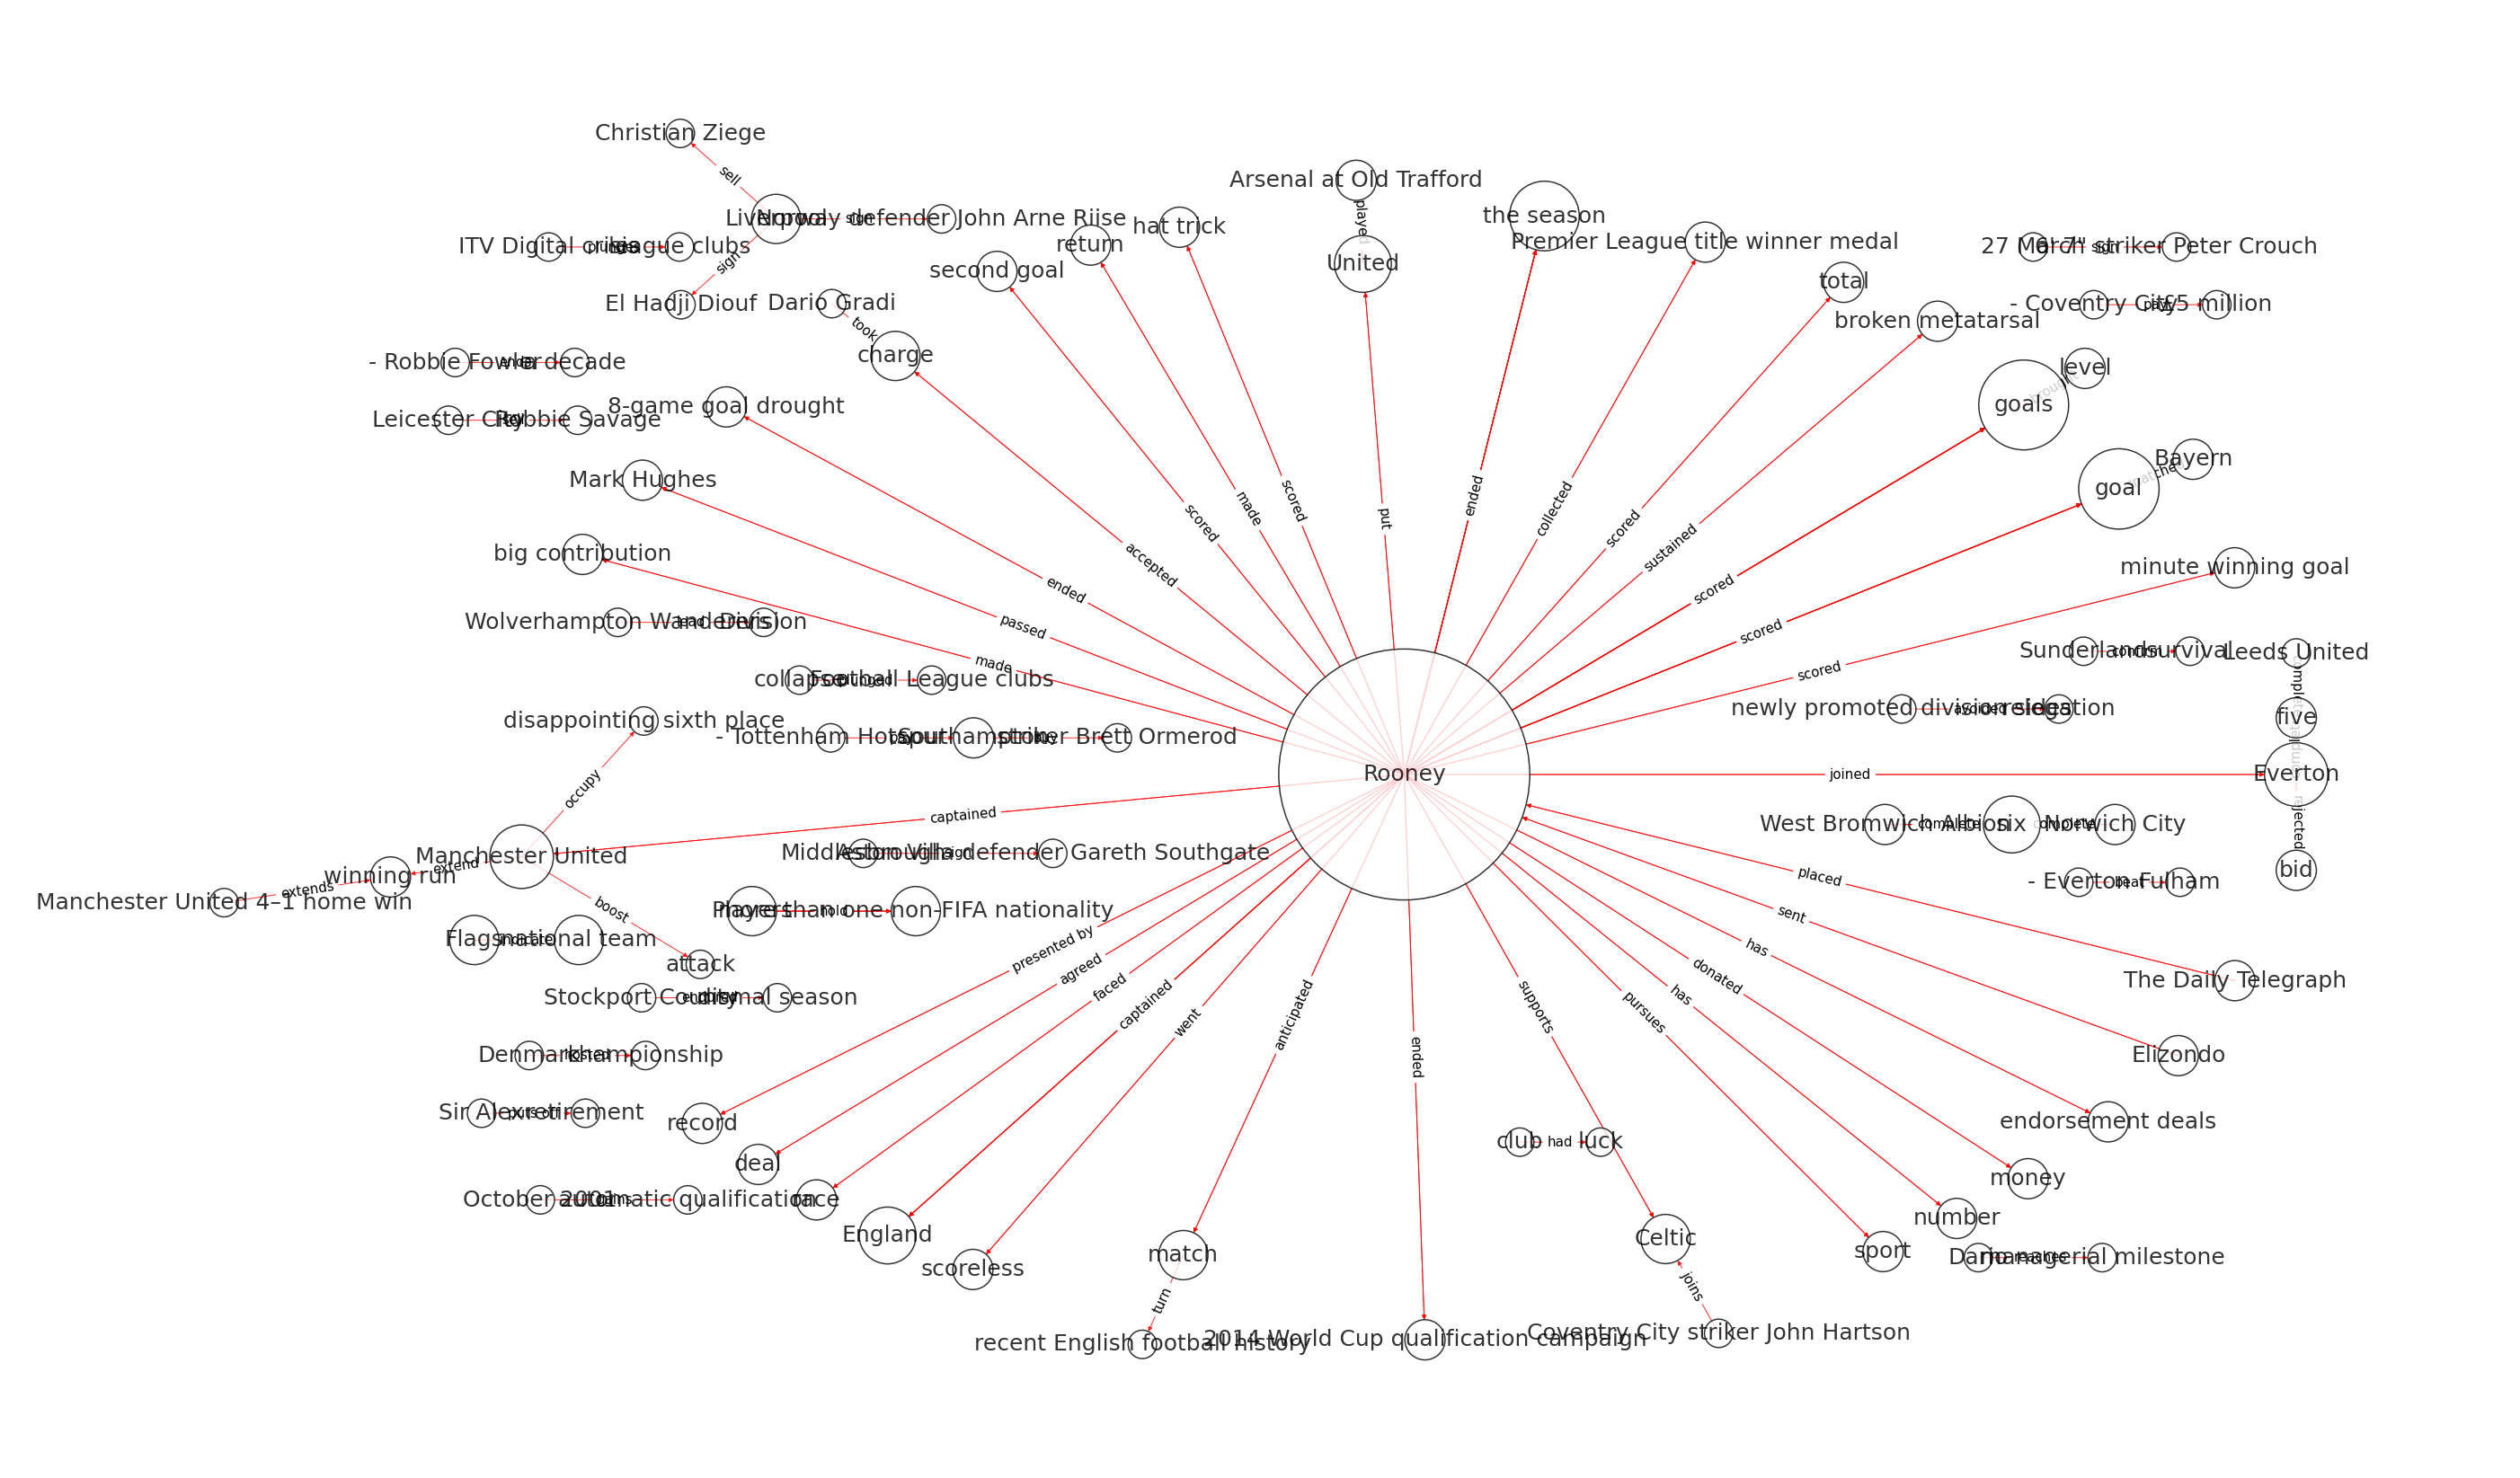

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
draw_pairs = draw_kg(pairs)

In [15]:

def filter_graph(pairs, node):
    import plotly.graph_objects as go
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    edges = nx.dfs_successors(k_graph, node)
    nodes = []
    
    for k, v in edges.items():
        nodes.extend([k])
        nodes.extend(v)
    subgraph = k_graph.subgraph(nodes)
    layout = (nx.spring_layout(k_graph))
    nx.draw_networkx(
        subgraph,
        node_size=1000,
        arrowsize=20,
        linewidths=1.5,
        pos= layout,
        edge_color='red',
        edgecolors='black',
        node_color='white'
        )
    
    labels = dict(zip((list(zip(pairs.subject, pairs.object))),
                    pairs['relation'].tolist()))
    edges= tuple(subgraph.out_edges(data=False))
    sublabels ={k: labels[k] for k in edges}
  
    nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=sublabels,
                                font_color='black')
    plt.axis('off')
    plt.show()

    return k_graph

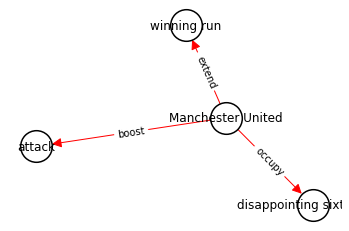

In [16]:
G = filter_graph(pairs, "Manchester United")

In [17]:
import plotly.graph_objects as go

pos = nx.spring_layout(G)# k=0.5, iterations=50)
for n, p in pos.items():
    G.nodes[n]['pos'] = p
    
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='RdBu',
        reversescale=True,
        color=[],
        size=15,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = adjacencies[0] +' # of connections: '+str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Wayne Rooney',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="No. of connections",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
iplot(fig)

In [18]:
wiki_data

,page,text,link,categories
0,Wayne Rooney,Wayne Mark Rooney (born 24 October 1985) is an...,https://en.wikipedia.org/wiki/Wayne_Rooney,"[1985 births, 2006 FIFA World Cup players, 201..."
1,1981–82 Manchester United F.C. season,The 1981–82 season was Manchester United's 80t...,https://en.wikipedia.org/wiki/1981%E2%80%9382_...,"[Articles with short description, English foot..."
2,2002–03 Everton F.C. season,"During the 2002–03 English football season, Ev...",https://en.wikipedia.org/wiki/2002%E2%80%9303_...,"[2002–03 FA Premier League by team, Articles w..."
3,2002 UEFA European Under-17 Championship,The 2002 UEFA European Under-17 Championship w...,https://en.wikipedia.org/wiki/2002_UEFA_Europe...,"[2001–02 in European football, 2002 UEFA Europ..."
4,2001–02 in English football,The 2001–02 season was the 122nd season of com...,https://en.wikipedia.org/wiki/2001%E2%80%9302_...,"[2001 in English sport, 2001 in European footb..."
...,...,...,...,...
828,Yorbe Vertessen,Yorbe Vertessen (born 8 January 2001) is a Bel...,https://en.wikipedia.org/wiki/Yorbe_Vertessen,"[2001 births, All stub articles, Articles with..."
829,Zack Steffen,"Zackary Thomas Steffen (born April 2, 1995) is...",https://en.wikipedia.org/wiki/Zack_Steffen,"[1995 births, 2015 CONCACAF U-20 Championship ..."
830,Ángel Di María,Ángel Fabián Di María (Spanish pronunciation: ...,https://en.wikipedia.org/wiki/%C3%81ngel_Di_Ma...,"[1988 births, 2010 FIFA World Cup players, 201..."
831,Zinedine Zidane,Zinedine Yazid Zidane (French pronunciation: ​...,https://en.wikipedia.org/wiki/Zinedine_Zidane,"[1972 births, 1998 FIFA World Cup players, 200..."


In [19]:
string = wiki_data.loc[0, "text"]
for i in range(500):

   string += wiki_data.loc[i, "text"]


In [20]:
text = nlp(string[0:1000000])


In [ ]:
!pip install TextBlob

In [ ]:
from textblob import TextBlob
df = wiki_data
df = df[~df['text'].isnull()]

def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText

df['Review Text'] = preprocess(df['text'])

df['polarity'] = df['Review Text'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['Review Text'].astype(str).apply(len)
df['word_count'] = df['Review Text'].apply(lambda x: len(str(x).split()))

In [ ]:
pip install chart_studio

     |████████████████████████████████| 71kB 2.1MB/s 


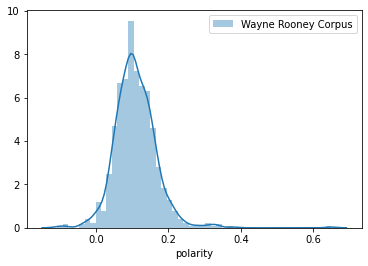

In [ ]:
import pandas as pd
import numpy as np
from plotly import __version__
%matplotlib inline
import cufflinks as cf
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 

sns.distplot(df['polarity'],
   # kind='hist',
    bins=50,
    label = 'Wayne Rooney Corpus'
    
)
plt.legend()

In [ ]:
trace2 = go.Histogram(
    x=df, name = 'Recommended',
    opacity=0.75
)

data = [trace2]
layout = go.Layout(barmode='overlay', title='Distribution of Sentiment polarity of reviews based on Recommendation')
fig = go.Figure(data=data, layout=layout)



In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import tweepy as tw
import nltk
from nltk.corpus import stopwords
import re
import networkx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

league 19181
season 14895
cup 14731
club 14647
team 11981
united 10980
goal 9043
match 8751
football 8627
world 8088
scored 7988
final 7719
win 7227
time 6961
year 6812
player 6742
goals 6580
second 6266
city 6048
game 5804


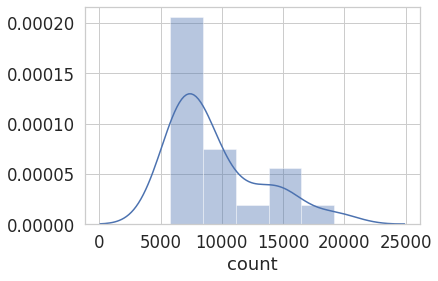

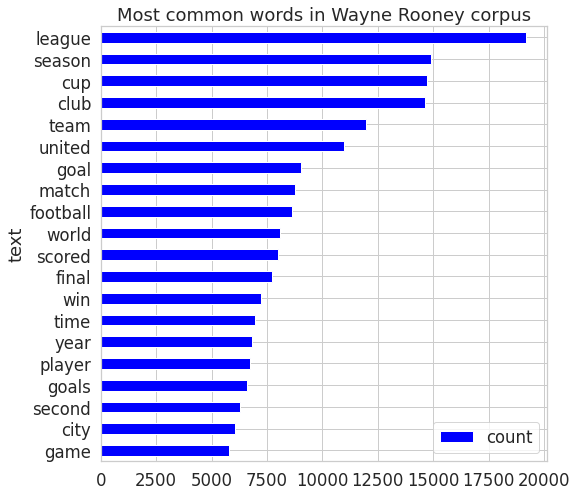

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['text'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])

sns.distplot(df2.groupby('text').sum()['count'].sort_values(ascending=False), 
)

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df2.sort_values(by='count').plot.barh(x='text',
                      y='count',
                      ax=ax,
                      color="blue")

ax.set_title("Most common words in Wayne Rooney corpus")

plt.show()

In [ ]:
len(df2['text'].to_list())

20

In [ ]:
pip install wordcloud

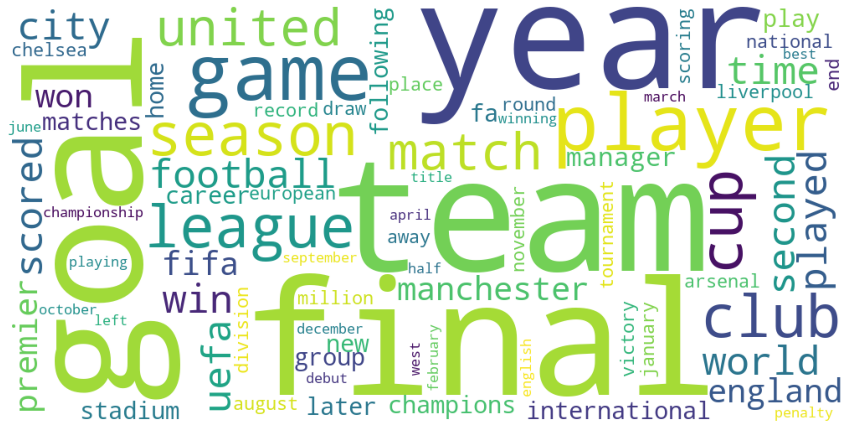

In [ ]:
common_words = get_top_n_words(df['text'], 100)

df3 = pd.DataFrame(common_words, columns = ['text' , 'count'])
my_list = df3['text'].to_list()

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#convert list to string and generate
unique_string=(" ").join(my_list)
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()